In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
from scipy.stats import pearsonr,gaussian_kde, chi2
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#SEED = 35010732 # from random.org
#np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:
def correlated_ts(c,delta_t = 0.1,N=1000):
    # parameters for coupled oscillator
    K,D = 1.0,1.0
    data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
    data2 = langevin.time_series(A=1/(K+np.abs(c)), D=D, delta_t=delta_t, N=N)
    x1 = (data1 + data2)/2
    if c>0:
        x2 = (data1 - data2)/2
    else:
        x2 = (data2-data1)/2

    return x1,x2

def c_rho(rho):
    return 2*np.abs(rho)/(1-np.abs(rho))*np.sign(rho)


In [3]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

In [4]:
def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

#def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
#    return (N/2/A**2 - 
#            q(aep,ass,ac,b)/A**3 +
#            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
#            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
#           1/A**2*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (-N/2/A**2 + 
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + 
                            dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2) +
                           2*b/A*dBdA(b,D,A,delta_t)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A)
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

def hessian(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    return np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])

In [5]:
def d2PdA2N(N,b,A,delta_t):
    return -N/2/A - N/(1-b**2)**2*dBdA(b,D,A,delta_t)**2*(1+b**2+6*b/(1+b))+2*N*b/(1-b**2)*dBdA(b,D,A,delta_t)

def d2PdAdDN(N,b,D,A,delta_t):
    return N*b/(1-b**2)*dBdD(b,A,delta_t) - N/(1-b**2)**2*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2+6*b/(1+b))

def d2PdD2N(N,b1,b2,D,A1,A2,delta_t):
    return (-N/(1-b1**2)**2*dBdD(b1,A1,delta_t)**2*(1+b1**2+6*b1/(1+b1))-
            N/(1-b2**2)**2*dBdD(b2,A2,delta_t)**2*(1+b2**2+6*b2/(1+b2)))

In [6]:
corr1k = pd.read_csv("correlations1k075.csv")
corr1k

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,da1dd,dasdd,a1ep,a1ss,a1c,a2ep,a2ss,a2c,c,dc
0,0.75,6.0,0.733877,0.962128,0.081525,0.140928,0.006214,0.987371,0.046603,3.909046e-06,0.000175,0.000023,2.017986,938.522352,691.852621,1.420734,140.827878,10.990045,5.840099,0.650825
1,0.75,6.0,0.751659,1.025867,0.091844,0.140822,0.006416,0.978539,0.046522,1.447011e-05,0.000179,0.000030,1.202985,1000.894104,756.833730,1.152442,141.230237,10.339081,6.299185,0.725884
2,0.75,6.0,0.771093,1.133624,0.102770,0.142298,0.006404,0.969878,0.045645,-1.175476e-05,0.000219,0.000020,1.261665,1107.061573,850.237228,1.180446,139.910589,19.631301,6.983247,0.814113
3,0.75,6.0,0.742883,1.055023,0.094962,0.148897,0.006727,0.967512,0.044828,2.058499e-05,0.000024,0.000029,1.001339,1030.988991,782.570095,2.084305,147.037772,17.974634,6.099069,0.707383
4,0.75,6.0,0.753399,1.040680,0.090860,0.141683,0.006384,0.992363,0.047638,-8.197222e-06,-0.000140,0.000027,2.727751,1014.275542,756.994940,1.231546,139.700137,17.872424,6.360374,0.727101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.75,6.0,0.741155,0.998428,0.087668,0.146820,0.006473,0.952423,0.044680,7.117678e-06,0.000113,0.000016,1.312729,977.731278,731.458842,1.000608,144.978802,21.070433,5.813230,0.666686
496,0.75,6.0,0.750625,1.039737,0.092790,0.144163,0.006509,0.996879,0.047512,3.071231e-07,0.000086,0.000034,1.341619,1014.139234,761.442210,1.104894,143.584773,13.926968,6.226872,0.722533
497,0.75,6.0,0.733635,1.005929,0.086278,0.146762,0.006527,1.008974,0.048621,-6.131198e-06,0.000063,0.000027,3.012383,979.928096,725.135040,1.020985,146.543377,14.256520,5.867920,0.666660
498,0.75,6.0,0.719022,0.947532,0.082170,0.151880,0.006750,0.937710,0.043692,-3.052511e-06,0.000066,0.000019,1.921877,925.467591,686.373312,1.000002,150.695602,21.493582,5.251090,0.611236


In [7]:
rho = 0.75
delta_t = 0.3
N = 1000
c = 2*rho/(1-rho)
guessa1 = 1.0
guessa2 = 1.0/(1.0+c)
guessd = 1.0
A1_list = []
A2_list = []
dA1_list = []
dA2_list = []
dA1dA2_list = []
dA1dD_list = []
dA2dD_list = []
C_list = []
dC_list = []
D_list = []
dD_list = []
tau1_list = []
dtau1_list = []
tau2_list = []
dtau2_list = []
print(guessa1,guessa2,guessd,c)
for index, row in corr1k.iterrows():
    a1ep,a1ss,a1c = row['a1ep'], row['a1ss'], row['a1c']
    a2ep,a2ss,a2c = row['a2ep'], row['a2ss'], row['a2c']
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],jac=hessian,args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    # lets calculate the Hessian
    h = hessian([A1,A2,D],a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    var = -np.linalg.inv(h)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    print(A1,dA1,A2,dA2,D,dD,C,dC)
    # add results to list
    A1_list.append(A1)
    A2_list.append(A2)
    dA1_list.append(dA1)
    dA2_list.append(dA2)
    D_list.append(D)
    dD_list.append(dD)
    dA1dA2_list.append(dA1A2)
    dA1dD_list.append(dA1dD)
    dA2dD_list.append(dA2dD)
    C_list.append(C)
    dC_list.append(dC)
    tau1_list.append(tau1)
    tau2_list.append(tau2)
    dtau1_list.append(dtau1)
    dtau2_list.append(dtau2)



1.0 0.14285714285714285 1.0 6.0
0.943006448123775 0.0467782889211992 0.1404250628655014 0.006034241555354579 0.9907367151844934 0.04125288365193767 5.715371379445156 0.3531313360601078
1.0038906981981066 0.049927436261279386 0.1422354617335236 0.006105033412705949 0.9747554258825368 0.04022199251966658 6.057949444976552 0.3668927673295194
1.1062502431619332 0.055410373956193706 0.1436146346355132 0.006191441955278542 0.9702753485647648 0.03996287583857461 6.702907478541734 0.4082913053701297
1.0319335894429065 0.05129688819445963 0.1421150758089005 0.006070894719554416 0.9616220123921744 0.039367659213708404 6.261253484679756 0.36711520522351165
1.0175501330047276 0.05077833754861415 0.14266933454092678 0.006158650413825194 0.9924442088301998 0.04127903341448357 6.132227372328765 0.38318722329066596
0.9546293168178182 0.04741125123062437 0.14170565526587897 0.00612092736393865 0.9490518634841655 0.03924880851436824 5.73670585007119 0.35610482611675903
0.9556476086280575 0.0479467551931

1.00180749165993 0.0496970620873151 0.14393524751281792 0.006171791909395556 0.9323237391613447 0.037986786617721036 5.960126230169686 0.3525431332646037
1.0856575665120556 0.05401987504535259 0.15020654037007508 0.006434994276560393 1.014677769862792 0.04163862290169512 6.2277649417744385 0.37662270662008074
1.0343535812262867 0.05164074116369004 0.1438673653597749 0.006203552059077561 1.0425228274382046 0.04367359282981611 6.189633164127509 0.3908748890722772
0.9483671794237614 0.04720210303905143 0.14171438225345218 0.006141991047156067 0.9610097971301462 0.039988857072581284 5.692102554048702 0.36126601205020653
0.8868085581230677 0.04386358572478429 0.14429769403945744 0.006250501595139388 1.0307809014407106 0.04352732032632668 5.145687663453406 0.33756843675351716
1.033241677572473 0.05149997349323893 0.142226845453447 0.006123622416887724 0.9494911513014812 0.03902911599504604 6.2647443896987 0.37904330203805003
1.1251730162671878 0.05633545648054058 0.1424478025074296 0.0060989

0.9563356652463133 0.04750729914627476 0.13688796276582596 0.005887544084701539 0.9005608367063671 0.03691066639740179 5.986265599425388 0.35558100021982303
0.9128820002068927 0.0450260005035594 0.1434119585744542 0.006141184210948379 0.9913129605177645 0.04105320236927463 5.365452430056298 0.3281400959734838
0.9493443446796663 0.047064516832644364 0.14331817536527416 0.006163269644729731 1.0406792721189535 0.04365032896053634 5.624033150436629 0.35482617700237384
0.9546201606025952 0.04714823325781573 0.1453154830567467 0.00623534989874134 0.9278830641717201 0.037775258292220976 5.569294204044379 0.33198818943821207
0.9936969958002094 0.04948484882819142 0.14282815121627673 0.006157308305252885 1.0167950667778376 0.042484523739178257 5.957290893554376 0.3745136514565139
0.9817347674155675 0.04881688953526495 0.1445507548975323 0.006236986210128551 1.027744233237922 0.04300474684347977 5.7916267065605425 0.367558148310714
1.0602641405002515 0.05361386893463718 0.1301417214010562 0.0056

1.0102605624573588 0.05034104759384903 0.14343912451014668 0.0061702285650964365 1.0163017946572321 0.04232099782808135 6.043131125538168 0.37572339743568944
1.0297578787389325 0.05146870572018003 0.139893835846987 0.006029980620624969 0.9988441047981222 0.041667170525648785 6.360995375559367 0.3949578298064933
0.9712919918675279 0.048382031398523255 0.14276747105499055 0.006187867022430547 1.029292264396459 0.0433714101952817 5.803314401313517 0.375941997737848
0.9569453522964018 0.04803766204328085 0.1318546687230567 0.005752174596667847 1.0097443212855148 0.04322118311135612 6.257576554276882 0.41481612000151985
0.995211848120573 0.04956638877420329 0.14372329266855355 0.006192841254324766 1.0298900406570313 0.04308217746052218 5.924499360139722 0.3735573288693219
1.0760127305412361 0.053338920420639 0.15452294258382862 0.006604674036033295 1.0135055595717517 0.04129375770845718 5.963449650575349 0.3577494242522712
1.210752654725147 0.0606898060063108 0.14446020973738133 0.006152847

1.0340397027738208 0.051835503849331936 0.14078718047491934 0.006107947987993105 1.0816346711514342 0.04606206812295141 6.34470069849883 0.4155132011062413
0.8592815617722676 0.04235891478899447 0.1439928129948566 0.006235290518971566 1.0479205092556665 0.044479241321679026 4.967530905885982 0.32844289359900264
0.9531169735583037 0.04721521715574286 0.14670993966052626 0.006325540248126294 1.0417831431609053 0.04363003897156443 5.496608040080526 0.3509658860235794
0.9963338317877085 0.04968335389260785 0.14205982381377372 0.006142060540672716 1.0080960506134526 0.04219045955682706 6.013480694540372 0.381405772502981
1.1009007784550382 0.055079240012050064 0.14389617691899015 0.006196611497578545 0.9765532223390829 0.04022616734265352 6.650660372129393 0.4041894707828745
1.2272675146392948 0.06144153143169555 0.15573191331736488 0.0066771309849440975 1.0225347095126858 0.04163969630765233 6.880642371215562 0.41321547628589494
0.9191572431836308 0.04550915913696859 0.14104392646147698 0.

1.1070483630401788 0.05525164903526999 0.14528864827614654 0.006227399478268569 0.9533703837093628 0.038839233704511616 6.619648032900956 0.389682254274942
1.0101224159106237 0.050463282006613694 0.14112296900659405 0.006095760657752977 1.0572337274464187 0.04466643596304165 6.157746347183393 0.39449753708880925
0.9139154643687297 0.04466845077122161 0.15645692352570126 0.006695139680090409 0.9564216035286838 0.03860959442813934 4.841323245874769 0.2919584808188214
0.9855636671555861 0.04867658632286519 0.14918558291034362 0.0063781188303022275 0.9704293348576705 0.039542996827266606 5.606292966981148 0.334266924519222
0.9392778066578165 0.04658935674737232 0.14313477824728388 0.0061785477514978634 1.0380407947257986 0.0436966557080064 5.562191370675074 0.35681759900263477
0.916933377393285 0.045558289498995506 0.14143848684523694 0.006132827172523637 0.965935766443436 0.04032530897870048 5.482912804324613 0.3511916864517122
1.0632023588647275 0.05282656835979884 0.14220124032680453 0.

0.9221891321809 0.04579533690193932 0.14268690050056484 0.006187696531297491 1.0583696854788753 0.04499351180622242 5.463025890573952 0.36060523523165355
0.8684621442281958 0.04265162272883318 0.15133414236894105 0.006541859361946043 1.0910300847355285 0.04623358751548255 4.7387059564586 0.31553028203928557
1.0164722848815506 0.05090632104971949 0.14284702257545565 0.006221189216054987 1.0306079568748348 0.04354958788961805 6.115810092188814 0.4020187547461811
0.9702323061251413 0.04842738208140316 0.13906582867063713 0.006025244824822051 1.0122534377526178 0.04268222859099772 5.976784414976846 0.38441721183388156
0.8798493890137502 0.04324458233749317 0.14625701005130995 0.0062811457535265494 0.9911435863219659 0.04106968422437547 5.015775850368342 0.31291567728646424
0.9105348185912704 0.04486181313833748 0.14099382298747487 0.006019085104008503 0.9225081599979739 0.037619154045107794 5.457976663787302 0.318548016337103
1.1725348981278467 0.05851861634033992 0.15565983387054025 0.006

In [8]:
corr1k['A1'] = A1_list
corr1k['A2'] = A2_list
corr1k['dA1'] = dA1_list
corr1k['dA2'] = dA2_list
corr1k['D'] = D_list
corr1k['dD'] = dD_list
corr1k['dA1dA2'] = dA1dA2_list
corr1k['dA1dD'] = dA1dD_list
corr1k['dA2dD'] = dA2dD_list
corr1k['C'] = C_list
corr1k['dC'] = dC_list
corr1k['tau1'] = tau1_list
corr1k['tau2'] = tau2_list
corr1k['dtau1'] = dtau1_list
corr1k['dtau2'] = dtau2_list

In [9]:
corr1k

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,...,dD,dA1dA2,dA1dD,dA2dD,C,dC,tau1,tau2,dtau1,dtau2
0,0.75,6.0,0.733877,0.962128,0.081525,0.140928,0.006214,0.987371,0.046603,3.909046e-06,...,0.041253,0.000029,0.001320,0.000037,5.715371,0.353131,0.951823,0.141738,0.290609,0.292741
1,0.75,6.0,0.751659,1.025867,0.091844,0.140822,0.006416,0.978539,0.046522,1.447011e-05,...,0.040222,0.000033,0.001379,0.000038,6.057949,0.366893,1.029890,0.145919,0.309763,0.312099
2,0.75,6.0,0.771093,1.133624,0.102770,0.142298,0.006404,0.969878,0.045645,-1.175476e-05,...,0.039963,0.000036,0.001535,0.000037,6.702907,0.408291,1.140141,0.148014,0.334931,0.337628
3,0.75,6.0,0.742883,1.055023,0.094962,0.148897,0.006727,0.967512,0.044828,2.058499e-05,...,0.039368,0.000036,0.001387,0.000041,6.261253,0.367115,1.073118,0.147787,0.320764,0.323190
4,0.75,6.0,0.753399,1.040680,0.090860,0.141683,0.006384,0.992363,0.047638,-8.197222e-06,...,0.041279,0.000030,0.001444,0.000036,6.132227,0.383187,1.025297,0.143756,0.306770,0.309151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.75,6.0,0.741155,0.998428,0.087668,0.146820,0.006473,0.952423,0.044680,7.117678e-06,...,0.038667,0.000036,0.001278,0.000042,5.694460,0.340243,1.032053,0.154165,0.313451,0.315709
496,0.75,6.0,0.750625,1.039737,0.092790,0.144163,0.006509,0.996879,0.047512,3.071231e-07,...,0.041125,0.000033,0.001430,0.000039,6.084617,0.372414,1.022693,0.144354,0.305461,0.307810
497,0.75,6.0,0.733635,1.005929,0.086278,0.146762,0.006527,1.008974,0.048621,-6.131198e-06,...,0.042005,0.000031,0.001408,0.000039,5.875403,0.361866,0.974961,0.141804,0.292623,0.294846
498,0.75,6.0,0.719022,0.947532,0.082170,0.151880,0.006750,0.937710,0.043692,-3.052511e-06,...,0.037856,0.000035,0.001175,0.000043,5.575252,0.318395,0.997296,0.151674,0.307967,0.310075


In [10]:
# display statistics
print(corr1k['A1'].mean(),corr1k['A1'].std(),corr1k['dA1'].mean(),corr1k['dA1'].std())
print(corr1k['a1'].mean(),corr1k['a1'].std(),corr1k['da1'].mean(),corr1k['da1'].std())
print(corr1k['A2'].mean(),corr1k['A2'].std(),corr1k['dA2'].mean(),corr1k['dA2'].std())
print(corr1k['a2'].mean(),corr1k['a2'].std(),corr1k['da2'].mean(),corr1k['da2'].std())
print(corr1k['C'].mean(),corr1k['C'].std(),corr1k['dC'].mean(),corr1k['dC'].std())
print(corr1k['c'].mean(),corr1k['c'].std(),corr1k['dc'].mean(),corr1k['dc'].std())

0.9969268202261269 0.0791686022123406 0.04961235239335175 0.0041919397302096605
1.018418242364077 0.08265290782519102 0.08776610683557755 0.011122793094691087
0.1436802207609717 0.00482865720183727 0.006191887739920152 0.00019867996822886164
0.14460073225690281 0.0062244991668316835 0.006485912373006178 0.0003041893005453392
5.943159886473833 0.5592452050767406 0.3712106513576289 0.03492502825162679
6.067036848321388 0.6112054242104263 0.6860788388252989 0.0821039218796532


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


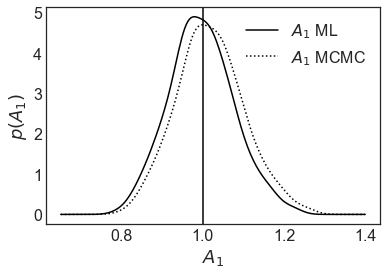

In [11]:
plt.figure(facecolor="white")
xs = np.linspace(0.65,1.4,200)
densityA1 = gaussian_kde(corr1k['A1'])
densitya1 = gaussian_kde(corr1k['a1'])
plt.plot(xs,densityA1(xs),"k-",label=r"$A_{1}$ ML")
plt.plot(xs,densitya1(xs),"k:",label=r"$A_{1}$ MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A_1$")
plt.ylabel(r"$p(A_{1})$")
plt.savefig("A1kde075.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


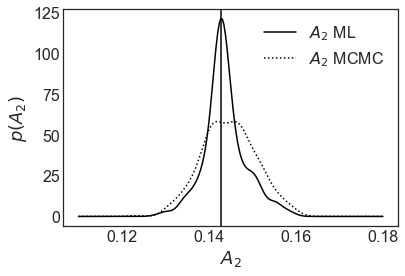

In [12]:
plt.figure(facecolor="white")
xs = np.linspace(0.11,0.18,200)
densityA2 = gaussian_kde(corr1k['A2'])
densitya2 = gaussian_kde(corr1k['a2'])
plt.plot(xs,densityA2(xs),"k-",label=r"$A_{2}$ ML")
plt.plot(xs,densitya2(xs),"k:",label=r"$A_{2}$ MCMC")
plt.axvline(x=1.0/7.0,color="k")
plt.legend()
plt.xlabel(r"$A_2$")
plt.ylabel(r"$p(A_{2})$")
plt.savefig("A2kde075.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [13]:
# display statistics
print(corr1k['dA1dA2'].mean(),corr1k['dA1dA2'].std(),corr1k['dA1dD'].mean(),corr1k['dA2dD'].mean())
print(corr1k['da1da2'].mean(),corr1k['dA1dA2'].std(),corr1k['da1dd'].mean(),corr1k['dasdd'].mean())

3.042964867013818e-05 5.898084156782888e-06 0.0014302919507540425 3.717653459721198e-05
1.5625341590299149e-06 5.898084156782888e-06 0.00012622234939041344 2.3436306716467814e-05


(array([ 2.,  1., 10., 11.,  8., 21., 26., 27., 32., 40., 38., 47., 36.,
        43., 29., 33., 15., 17., 14., 16.,  8.,  7.,  9.,  4.,  2.,  1.,
         1.,  1.,  0.,  1.]),
 array([0.06089473, 0.06312653, 0.06535832, 0.06759012, 0.06982191,
        0.07205371, 0.0742855 , 0.0765173 , 0.07874909, 0.08098089,
        0.08321268, 0.08544448, 0.08767627, 0.08990807, 0.09213986,
        0.09437166, 0.09660345, 0.09883525, 0.10106704, 0.10329884,
        0.10553063, 0.10776243, 0.10999422, 0.11222602, 0.11445781,
        0.11668961, 0.1189214 , 0.1211532 , 0.12338499, 0.12561679,
        0.12784858]),
 <BarContainer object of 30 artists>)

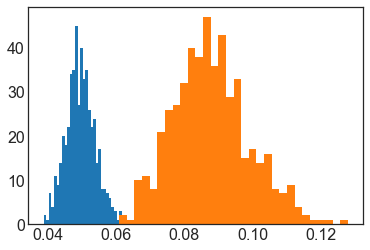

In [14]:
plt.hist(corr1k['dA1'],bins=30)
plt.hist(corr1k['da1'],bins=30)

(array([ 1.,  0.,  0.,  1.,  1.,  4.,  2.,  8., 13., 12., 16., 21., 40.,
        43., 36., 36., 35., 36., 46., 28., 34., 32., 15.,  9., 12.,  8.,
         7.,  2.,  0.,  2.]),
 array([0.00542286, 0.00548741, 0.00555195, 0.0056165 , 0.00568104,
        0.00574559, 0.00581013, 0.00587468, 0.00593922, 0.00600377,
        0.00606831, 0.00613286, 0.0061974 , 0.00626195, 0.00632649,
        0.00639104, 0.00645558, 0.00652013, 0.00658467, 0.00664922,
        0.00671376, 0.00677831, 0.00684285, 0.0069074 , 0.00697194,
        0.00703649, 0.00710103, 0.00716558, 0.00723012, 0.00729467,
        0.00735921]),
 <BarContainer object of 30 artists>)

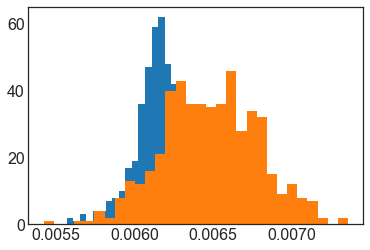

In [15]:
plt.hist(corr1k['dA2'],bins=30)
plt.hist(corr1k['da2'],bins=30)

In [16]:
print(corr1k['A1'].std()/corr1k['dA1'].mean())
print(corr1k['A2'].std()/corr1k['dA2'].mean())
print(corr1k['D'].std()/corr1k['dD'].mean())
print(corr1k['dA1dA2'].mean()/corr1k['da1da2'].mean())
print(corr1k['dA1dD'].mean()/corr1k['da1dd'].mean())
print(corr1k['dA2dD'].mean()/corr1k['dasdd'].mean())

1.595743769306724
0.7798360378380403
1.150910501940649
19.47454940059048
11.33152692579079
1.586279572416136


(array([ 1.,  1.,  1.,  2.,  3.,  6.,  9., 11.,  8., 16., 15., 26., 26.,
        39., 48., 43., 35., 38., 25., 26., 28., 40., 15., 14.,  7.,  5.,
         3.,  5.,  3.,  1.]),
 array([-3.99968172e-05, -3.74142309e-05, -3.48316445e-05, -3.22490581e-05,
        -2.96664718e-05, -2.70838854e-05, -2.45012990e-05, -2.19187127e-05,
        -1.93361263e-05, -1.67535399e-05, -1.41709535e-05, -1.15883672e-05,
        -9.00578081e-06, -6.42319444e-06, -3.84060807e-06, -1.25802170e-06,
         1.32456467e-06,  3.90715104e-06,  6.48973740e-06,  9.07232377e-06,
         1.16549101e-05,  1.42374965e-05,  1.68200829e-05,  1.94026692e-05,
         2.19852556e-05,  2.45678420e-05,  2.71504284e-05,  2.97330147e-05,
         3.23156011e-05,  3.48981875e-05,  3.74807738e-05]),
 <BarContainer object of 30 artists>)

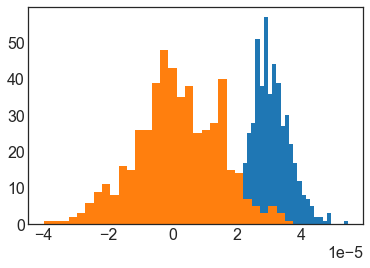

In [17]:
plt.hist(corr1k['dA1dA2'],bins=30)
plt.hist(corr1k['da1da2'],bins=30)

(array([ 1.,  1.,  4.,  1.,  5.,  2.,  4., 11., 16., 21., 24., 28., 28.,
        28., 30., 40., 38., 36., 30., 33., 29., 21., 18., 22., 15.,  6.,
         0.,  5.,  1.,  2.]),
 array([-1.81793626e-04, -1.62593019e-04, -1.43392412e-04, -1.24191804e-04,
        -1.04991197e-04, -8.57905900e-05, -6.65899828e-05, -4.73893756e-05,
        -2.81887685e-05, -8.98816129e-06,  1.02124459e-05,  2.94130531e-05,
         4.86136602e-05,  6.78142674e-05,  8.70148746e-05,  1.06215482e-04,
         1.25416089e-04,  1.44616696e-04,  1.63817303e-04,  1.83017910e-04,
         2.02218518e-04,  2.21419125e-04,  2.40619732e-04,  2.59820339e-04,
         2.79020946e-04,  2.98221554e-04,  3.17422161e-04,  3.36622768e-04,
         3.55823375e-04,  3.75023982e-04,  3.94224589e-04]),
 <BarContainer object of 30 artists>)

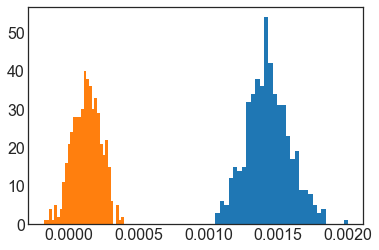

In [18]:
plt.hist(corr1k['dA1dD'],bins=30)
plt.hist(corr1k['da1dd'],bins=30)

(array([ 1.,  0.,  6.,  2.,  5., 10., 19., 14., 14., 13., 18., 33., 41.,
        33., 32., 31., 36., 38., 19., 27., 31., 17., 16., 16.,  8.,  6.,
         6.,  2.,  2.,  4.]),
 array([2.77503689e-06, 4.12577116e-06, 5.47650544e-06, 6.82723972e-06,
        8.17797399e-06, 9.52870827e-06, 1.08794425e-05, 1.22301768e-05,
        1.35809111e-05, 1.49316454e-05, 1.62823797e-05, 1.76331139e-05,
        1.89838482e-05, 2.03345825e-05, 2.16853168e-05, 2.30360510e-05,
        2.43867853e-05, 2.57375196e-05, 2.70882539e-05, 2.84389881e-05,
        2.97897224e-05, 3.11404567e-05, 3.24911910e-05, 3.38419252e-05,
        3.51926595e-05, 3.65433938e-05, 3.78941281e-05, 3.92448624e-05,
        4.05955966e-05, 4.19463309e-05, 4.32970652e-05]),
 <BarContainer object of 30 artists>)

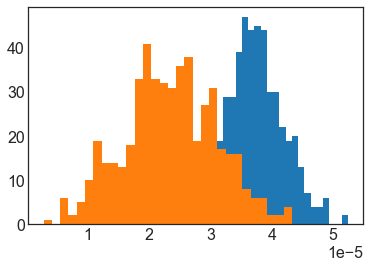

In [19]:
plt.hist(corr1k['dA2dD'],bins=30)
plt.hist(corr1k['dasdd'],bins=30)

[0.36182721 0.01785619]
factor of underestimation:  2.763750171348021


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


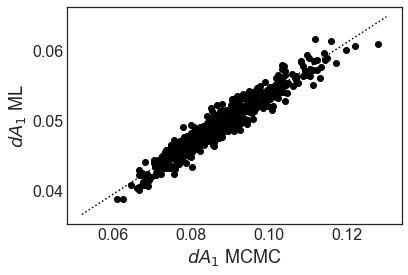

In [20]:
p1 = np.polyfit(corr1k['da1'],corr1k['dA1'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da1 = np.linspace(0.052,0.13,200)
dA1 = p1[0]*da1 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k['da1'],corr1k['dA1'],color="k")
plt.plot(da1,dA1,"k:")
plt.xlabel(r"$dA_1$ MCMC")
plt.ylabel(r"$dA_{1}$ ML")
plt.savefig("dA1corrkde075.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

[0.40981165 0.00353389]
factor of underestimation:  2.4401453522717254


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


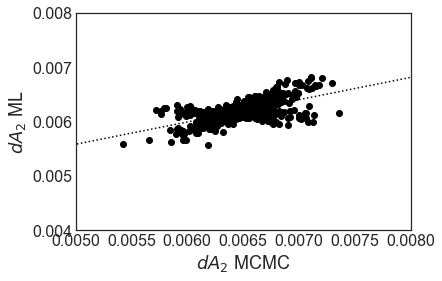

In [21]:
p1 = np.polyfit(corr1k['da2'],corr1k['dA2'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da2 = np.linspace(0.004,0.01,200)
dA2 = p1[0]*da2 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k['da2'],corr1k['dA2'],color="k")
plt.plot(da2,dA2,"k:")
plt.xlabel(r"$dA_2$ MCMC")
plt.ylabel(r"$dA_{2}$ ML")
plt.xlim((0.005,0.008))
plt.ylim((0.004,0.008))
plt.savefig("dA2corrkde075.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [22]:
corr1k['dA2'].min()

0.00556992743224769